<a href="https://colab.research.google.com/github/Subhoshri/Alphabet-Sign-Language-Detection/blob/main/Sign_Language.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing all the necessary libraries.

In [ ]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import utils, callbacks
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from sklearn import metrics
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from glob import glob
import sklearn
!pip install visualkeras
import visualkeras
!pip install ann-visualizer
import ann_visualizer
from ann_visualizer.visualize import ann_viz

In [ ]:
 !pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"up14cp9225","key":"fb2dc9c6bc4010df97628a90a762f1f3"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d prathumarikeri/indian-sign-language-isl

Dataset URL: https://www.kaggle.com/datasets/prathumarikeri/indian-sign-language-isl
License(s): CC-BY-SA-4.0
indian-sign-language-isl.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!mkdir dataset

In [ ]:
!unzip indian-sign-language-isl.zip -d dataset

Streaming output truncated to the last 5000 lines.
  inflating: dataset/Indian/V/819.jpg  
  inflating: dataset/Indian/V/82.jpg  
  inflating: dataset/Indian/V/820.jpg  
  inflating: dataset/Indian/V/821.jpg  
  inflating: dataset/Indian/V/822.jpg  
  inflating: dataset/Indian/V/823.jpg  
  inflating: dataset/Indian/V/824.jpg  
  inflating: dataset/Indian/V/825.jpg  
  inflating: dataset/Indian/V/826.jpg  
  inflating: dataset/Indian/V/827.jpg  
  inflating: dataset/Indian/V/828.jpg  
  inflating: dataset/Indian/V/829.jpg  
  inflating: dataset/Indian/V/83.jpg  
  inflating: dataset/Indian/V/830.jpg  
  inflating: dataset/Indian/V/831.jpg  
  inflating: dataset/Indian/V/832.jpg  
  inflating: dataset/Indian/V/833.jpg  
  inflating: dataset/Indian/V/834.jpg  
  inflating: dataset/Indian/V/835.jpg  
  inflating: dataset/Indian/V/836.jpg  
  inflating: dataset/Indian/V/837.jpg  
  inflating: dataset/Indian/V/838.jpg  
  inflating: dataset/Indian/V/839.jpg  
  inflating: dataset/Indian/V/8

Loading the dataset path onto data.

In [ ]:
data='/content/dataset/Indian'

We will now apply *Gaussian Blur* to smooth the edges and reduce noise in the images. Also we'll find the appropriate threshold to distinguish the hand gesture from the background using *Adaptive Thresholding* and *Otsu Thresholding*. These features are applied to all the images in the dataset.

Furthermore, we split the dataset into 80% training and 20% test data. Every image is scaled to 64 x 64 pixels and normalised.

In [ ]:
def load_images():
    images=[]
    labels=[]
    idx=-1
    folders=sorted(os.listdir(data))

    for folder in folders:
        idx+=1

        print("Loading images from folder: ", folder)
        for image in os.listdir(data+'/'+folder):
            img = cv2.imread(data + '/' + folder + '/' + image, 0)

            img=edge_detection(img)
            img=cv2.resize(img,(64,64))
            img=img_to_array(img)
            images.append(img)
            labels.append(idx)

    images=np.array(images)
    images=images.astype('float32')/255.0
    labels=to_categorical(labels)

    x_train,x_test,y_train,y_test=train_test_split(images,labels,test_size=0.2)

    return x_train,x_test,y_train,y_test

def edge_detection(image):
    minValue=70
    blur=cv2.GaussianBlur(image,(5,5),2)
    th3=cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,2)
    ret,res=cv2.threshold(th3, minValue, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    return res

Now we load the images from folders while applying *edge_detection* function.

In [ ]:
x_train, x_test, y_train, y_test = load_images()

Loading images from folder:  1
Loading images from folder:  2
Loading images from folder:  3
Loading images from folder:  4
Loading images from folder:  5
Loading images from folder:  6
Loading images from folder:  7
Loading images from folder:  8
Loading images from folder:  9
Loading images from folder:  A
Loading images from folder:  B
Loading images from folder:  C
Loading images from folder:  D
Loading images from folder:  E
Loading images from folder:  F
Loading images from folder:  G
Loading images from folder:  H
Loading images from folder:  I
Loading images from folder:  J
Loading images from folder:  K
Loading images from folder:  L
Loading images from folder:  M
Loading images from folder:  N
Loading images from folder:  O
Loading images from folder:  P
Loading images from folder:  Q
Loading images from folder:  R
Loading images from folder:  S
Loading images from folder:  T
Loading images from folder:  U
Loading images from folder:  V
Loading images from folder:  W
Loading 

We will shuffle the data to prevent any bias from coming into the model due to the sorted dataset.

In [ ]:
from sklearn.utils import shuffle
x_train,y_train=shuffle(x_train, y_train, random_state=17)
x_test,y_test=shuffle(x_test, y_test, random_state=17)

Plotting an example from the dataset after it has been cleaned.

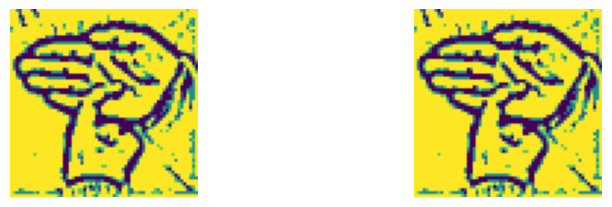

In [ ]:
alpha=[chr(c) for c in range(65,91)]
uniq,count=np.unique(y_train,return_counts=True)

j=1
plt.figure(figsize=(20,20))
for i in uniq:
    plt.subplot(7,4,j)
    plt.imshow(x_train[np.where(y_train==np.array(i))[0][0]])
    plt.axis('off')
    j=j+1

Mapping each character to an index starting from 0.

In [ ]:
map_characters = {0: '1', 1: '2', 2: '3', 3: '4', 4: '5', 5: '6', 6: '7', 7: '8', 8: '9', 9: 'A', 10: 'B', 11: 'C', 12: 'D',
                  13: 'E', 14: 'F', 15: 'G', 16: 'H', 17: 'I', 18: 'J', 19: 'K', 20: 'L', 21: 'M', 22: 'N', 23: 'O', 24: 'P',
                  25: 'Q', 26: 'R', 27: 'S', 28: 'T', 29: 'U', 30: 'V', 31: 'W', 32: 'X', 33: 'Y', 34: 'Z'}

In [ ]:
model = Sequential([
    layers.Conv2D(32, (3,3), activation='relu', padding="same", input_shape=(64,64,1), kernel_regularizer=l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPool2D((2,2)),

    layers.Conv2D(64, (3,3), padding="same", activation='relu', kernel_regularizer=l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPool2D((2,2)),

    layers.Conv2D(64, (3,3), padding="same", activation='relu', kernel_regularizer=l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPool2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    layers.Dropout(0.4),
    layers.Dense(35, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
adam = Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [ ]:
train_generator = datagen.flow(x_train, y_train, batch_size=32)

epochs = 50
history = model.fit(train_generator, epochs=epochs, verbose=2, validation_data=(x_test, y_test), shuffle=True)

model.summary()

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1069/1069 - 36s - 34ms/step - accuracy: 0.2880 - loss: 2.8520 - val_accuracy: 0.7069 - val_loss: 1.2379
Epoch 2/50
1069/1069 - 33s - 31ms/step - accuracy: 0.6605 - loss: 1.4379 - val_accuracy: 0.9794 - val_loss: 0.4664
Epoch 3/50
1069/1069 - 28s - 26ms/step - accuracy: 0.8148 - loss: 0.9267 - val_accuracy: 0.9578 - val_loss: 0.4975
Epoch 4/50
1069/1069 - 27s - 25ms/step - accuracy: 0.8837 - loss: 0.6992 - val_accuracy: 0.9169 - val_loss: 0.5715
Epoch 5/50
1069/1069 - 26s - 24ms/step - accuracy: 0.9179 - loss: 0.5750 - val_accuracy: 0.9470 - val_loss: 0.4688
Epoch 6/50
1069/1069 - 27s - 25ms/step - accuracy: 0.9419 - loss: 0.4965 - val_accuracy: 0.8683 - val_loss: 0.6835
Epoch 7/50
1069/1069 - 25s - 24ms/step - accuracy: 0.9552 - loss: 0.4421 - val_accuracy: 0.8706 - val_loss: 0.7741
Epoch 8/50
1069/1069 - 25s - 24ms/step - accuracy: 0.9619 - loss: 0.4033 - val_accuracy: 0.7076 - val_loss: 1.7554
Epoch 9/50
1069/1069 - 42s - 39ms/step - accuracy: 0.9695 - loss: 0.3648 - val_accuracy: 0.

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 35)                  │           4,515 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,755,307 (6.70 MB)

 Trainable params: 584,995 (2.23 MB)

 Non-trainable params: 320 (1.25 KB)

 Optimizer params: 1,169,992 (4.46 MB)

/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


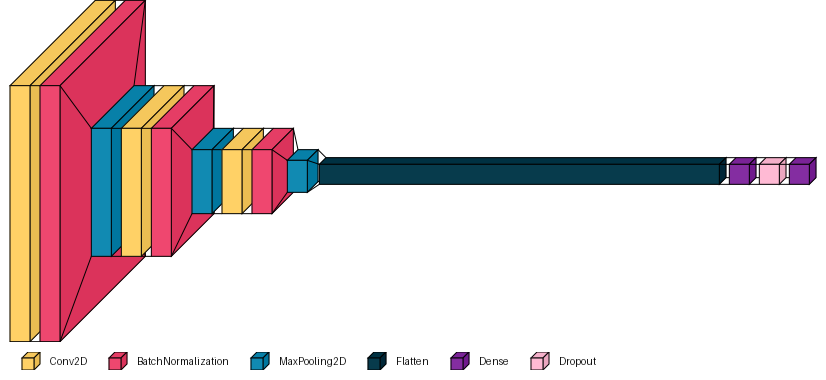

In [ ]:
visualkeras.layered_view(model,legend=True)

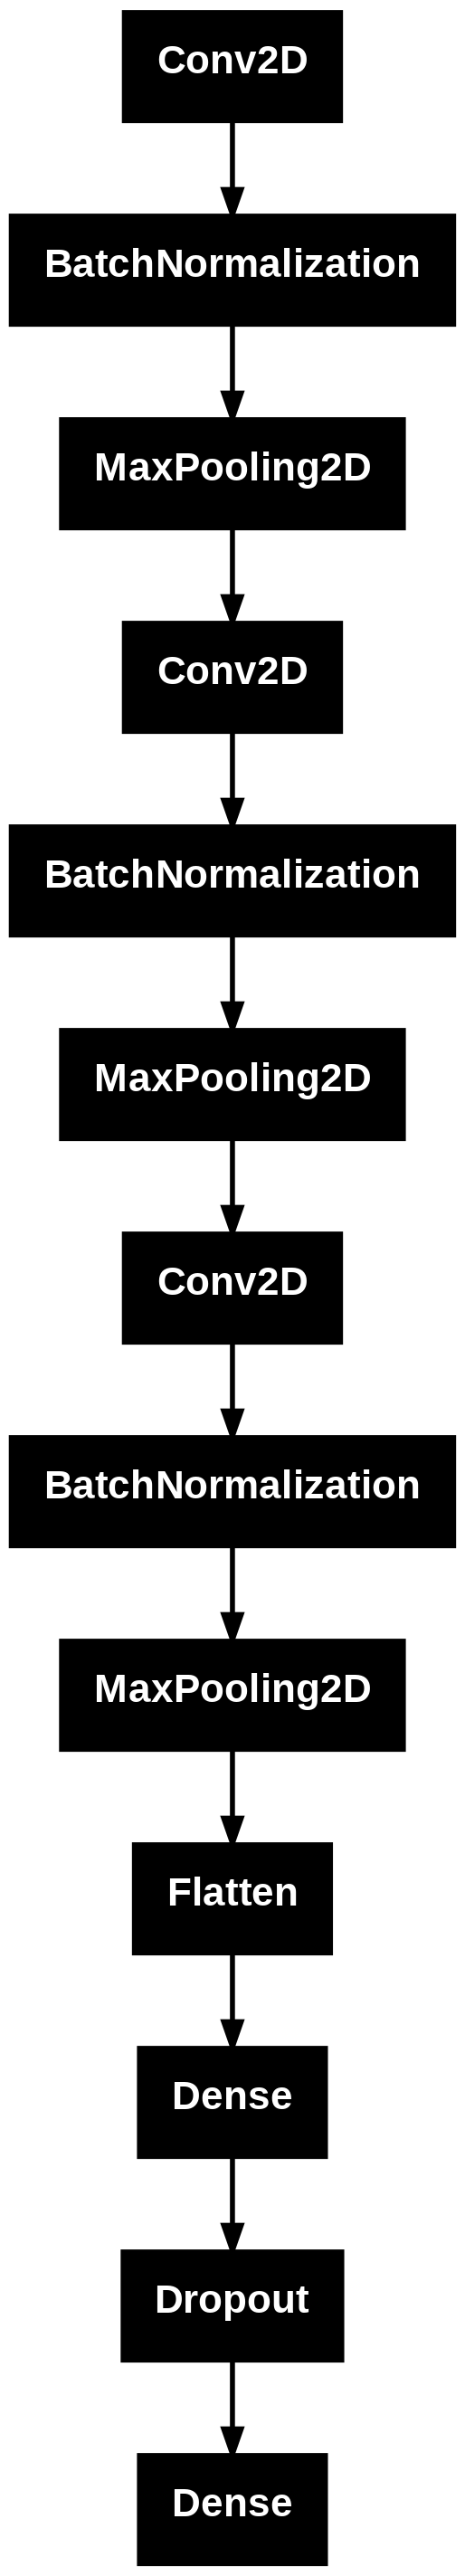

In [ ]:
keras.utils.plot_model(model)

In [ ]:
gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)
session = tf.compat.v1.InteractiveSession(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [ ]:
def plot_loss(epochs, loss, val_loss):
    plt.plot(epochs, loss, 'r-', label='Training Loss')
    plt.plot(epochs, val_loss, 'b-', label='Validation Loss')
    plt.yscale('log')
    plt.title('Training and Validation Loss (Log Scale)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (log scale)')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_accuracy(epochs, acc, val_acc):
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'orange', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
class_labels = list(map_characters.values())

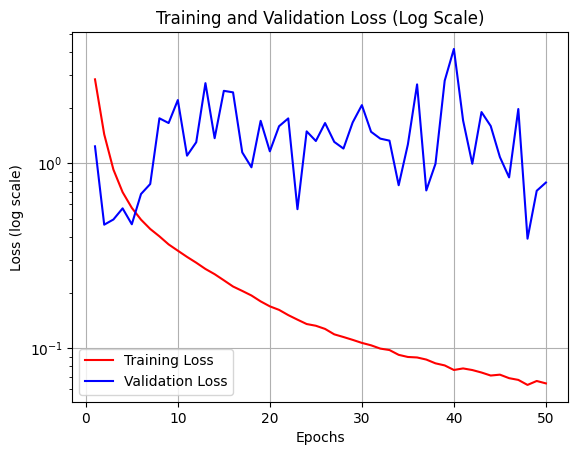

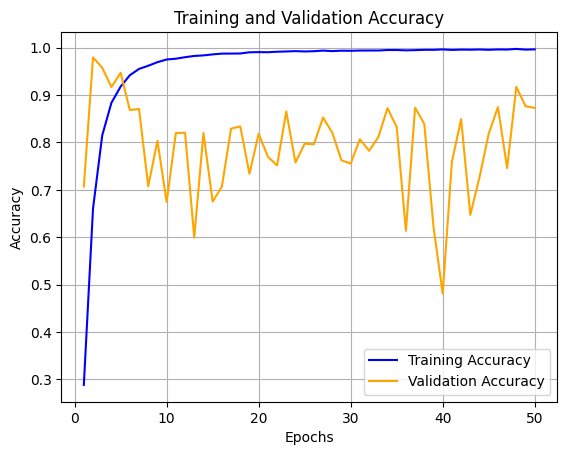

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

plot_loss(range(1, len(loss) + 1), loss, val_loss)
plot_accuracy(range(1, len(loss) + 1), acc, val_acc)

In [ ]:
score = model.evaluate(x_test,y_test, verbose=0)
print(score)
print('\nKeras CNN - accuracy:', score[1], '\n')

y_pred = model.predict(x_test, verbose = 1)
Y_pred_classes = np.argmax(y_pred,axis = 1)
Y_true = np.argmax(y_test,axis = 1)
report = metrics.classification_report(Y_true, Y_pred_classes, target_names=class_labels)
print(report)

[0.004389611538499594, 1.0]

Keras CNN - accuracy: 1.0 

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       253
           2       1.00      1.00      1.00       235
           3       1.00      1.00      1.00       223
           4       1.00      1.00      1.00       227
           5       1.00      1.00      1.00       247
           6       1.00      1.00      1.00       262
           7       1.00      1.00      1.00       226
           8       1.00      1.00      1.00       240
           9       1.00      1.00      1.00       253
           A       1.00      1.00      1.00       266
           B       1.00      1.00      1.00       244
           C       1.00      1.00      1.00       287
           D       1.00      1.00      1.00       207
           E       1.00      1.00      1.00       256
           F       1.00      1.00      1.00       235
           G       1.00      1.00    

In [ ]:
model.save('Sign_Language_Predict.h5')

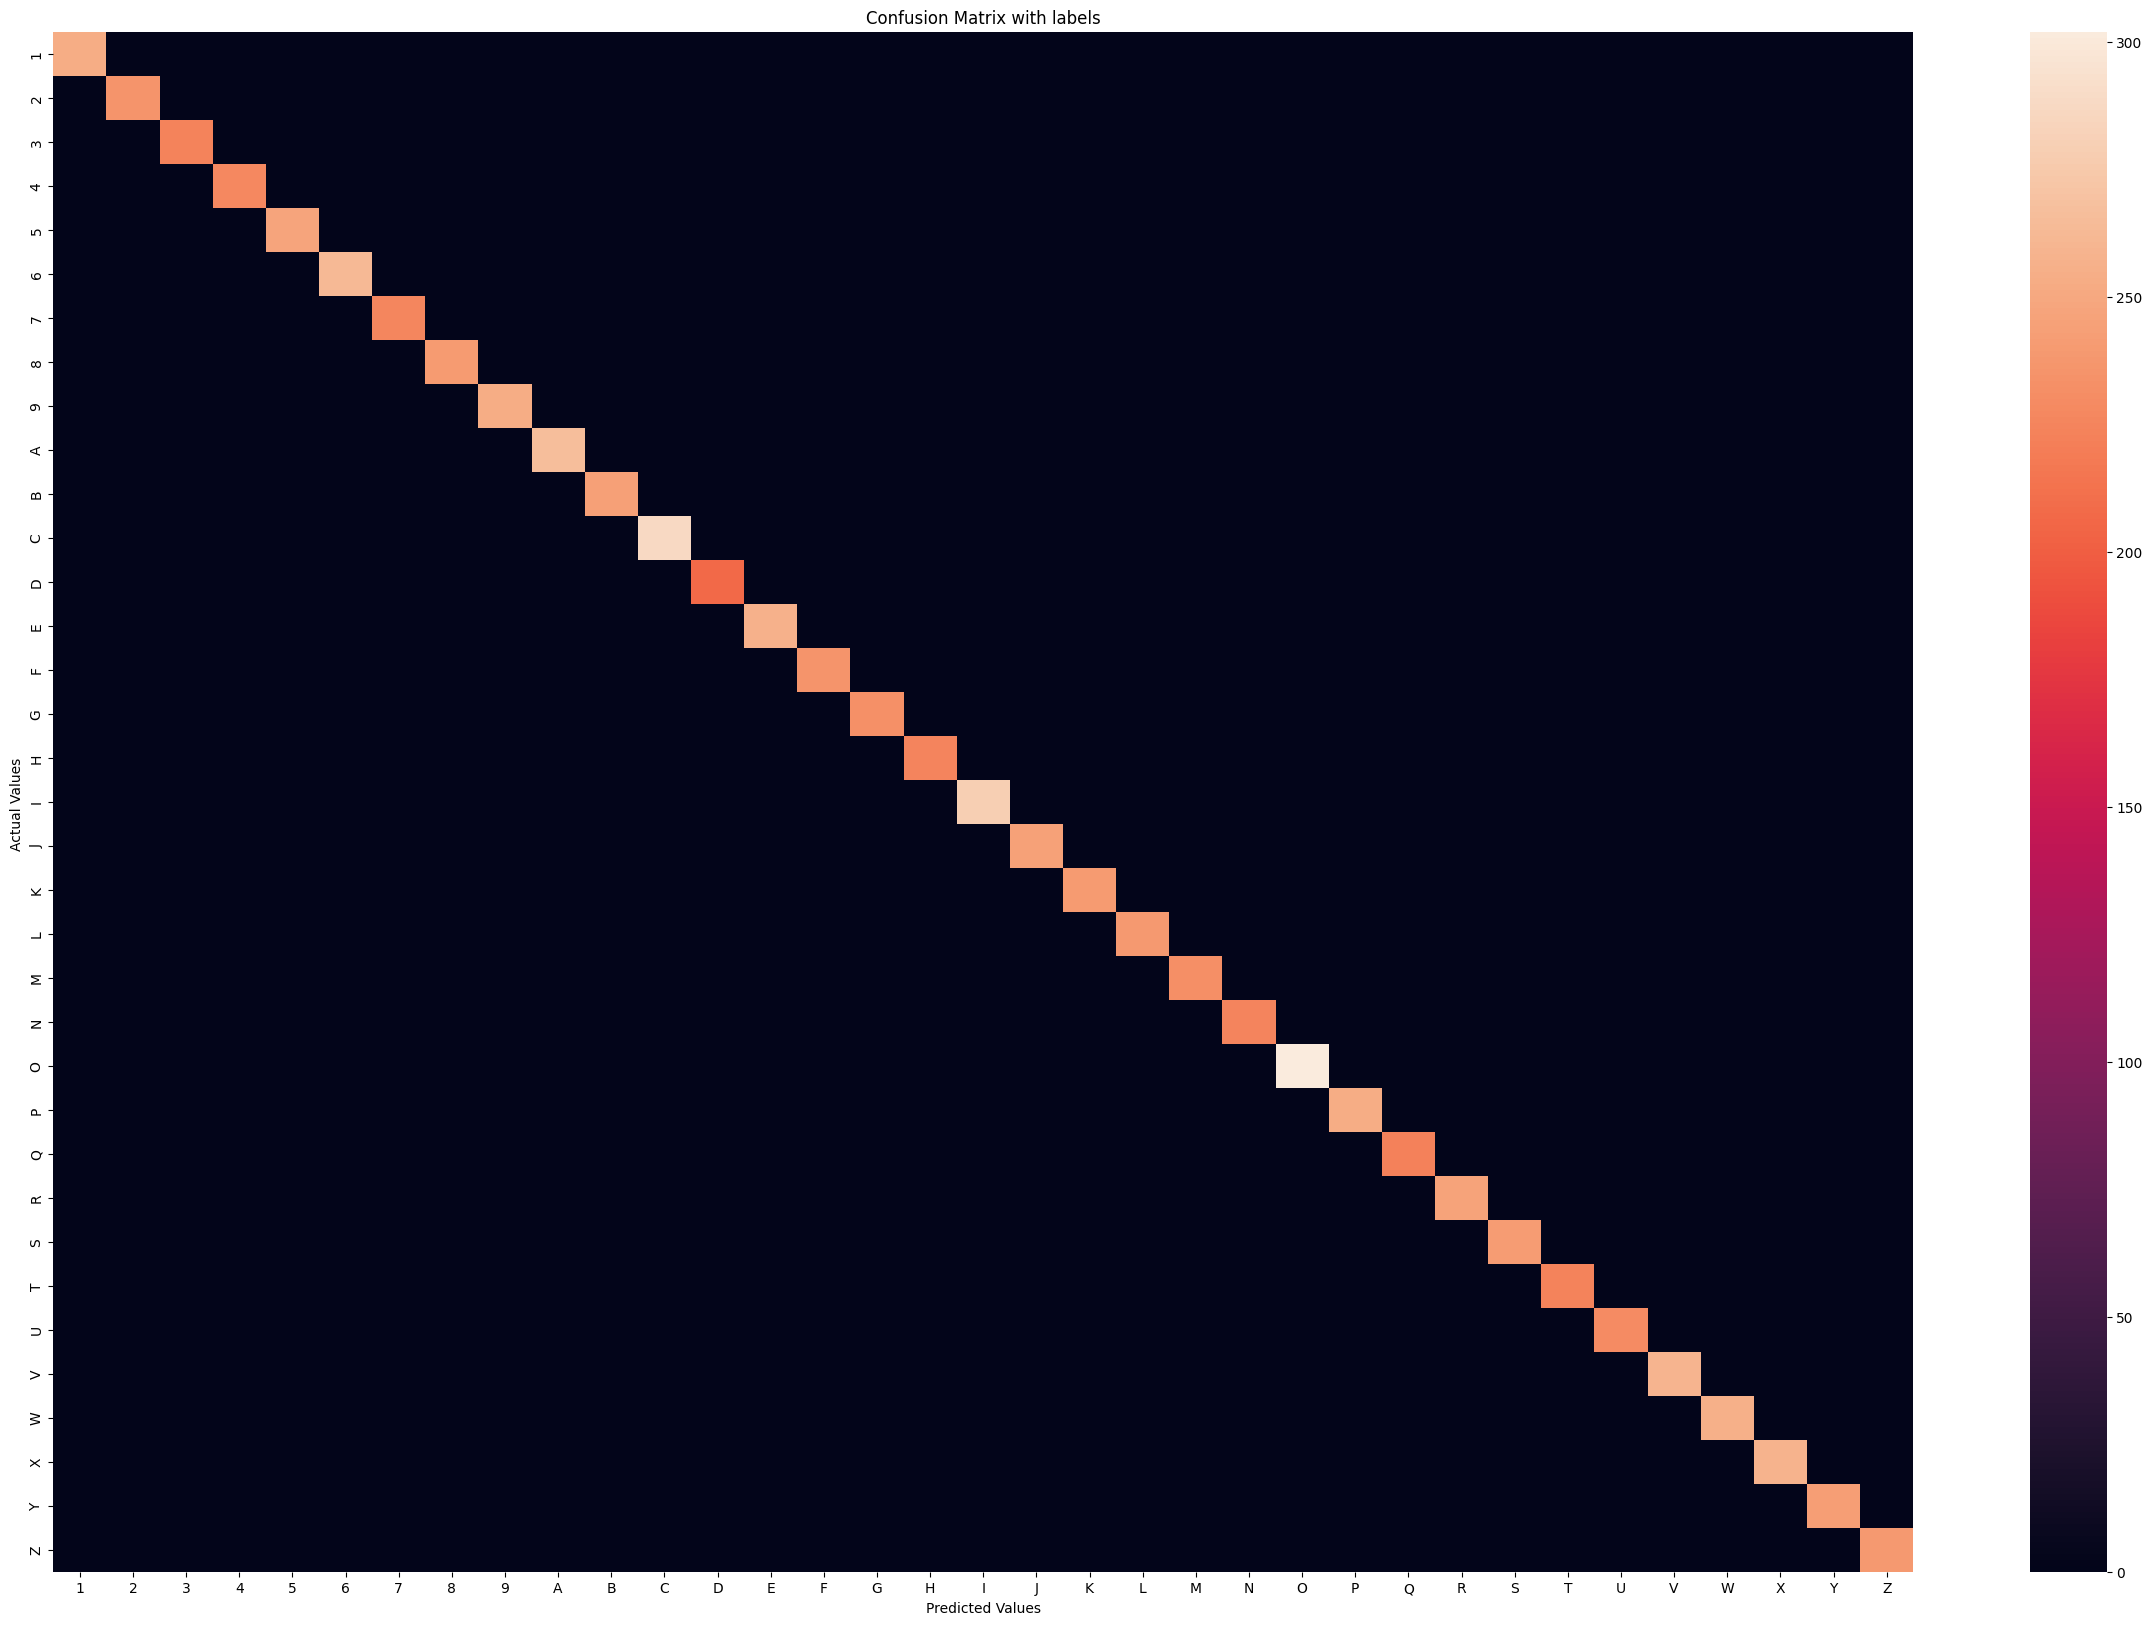

In [ ]:
plt.figure(figsize=(30, 20))

ax = sns.heatmap(metrics.confusion_matrix(Y_true,Y_pred_classes))
ax.set_title('Confusion Matrix with labels')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ')
ax.xaxis.set_ticklabels(class_labels)
ax.yaxis.set_ticklabels(class_labels)

plt.show()

In [ ]:
confusion = metrics.confusion_matrix(Y_true,Y_pred_classes)
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[253   0   0 ...   0   0   0]
 [  0 235   0 ...   0   0   0]
 [  0   0 223 ...   0   0   0]
 ...
 [  0   0   0 ... 258   0   0]
 [  0   0   0 ...   0 243   0]
 [  0   0   0 ...   0   0 239]]


In [ ]:
model=tf.keras.models.load_model('Sign_Language_Predict.h5')
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 35)                  │           4,515 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 585,317 (2.23 MB)

 Trainable params: 584,995 (2.23 MB)

 Non-trainable params: 320 (1.25 KB)

 Optimizer params: 2 (12.00 B)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
uploaded = files.upload()

for filename in uploaded.keys():
    image_path=filename

def predict_image(image_path, model):
    img=cv2.imread(image_path, 0)
    img=cv2.resize(img, (64, 64))
    img=img / 255.0
    img=np.expand_dims(img, axis=0)
    img=np.expand_dims(img, axis=-1)

    prediction = model.predict(img)
    predicted_class = np.argmax(prediction)

    print("Predicted Sign:", predicted_class)

predict_image(image_path, model)


Saving ccc.jpg to ccc (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Sign: 30
